In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL

from mac0460_5832.utils import *

########################################################################
#
# OBS:
#
# A função draw_img original lia o atributo shape como uma tupla
# (width, height). Como é mais natural descrever o shape de uma matriz
# como (linhas = height, colunas = width), eu optei por modificar essa
# função para ler os vetores dessa maneira. Os resultados não devem se
# alterar, apenas virar.


########################################################################
#
# Classes                                                       
#
###
# WOperator Learner Class
class WOperatorLearner:
    """ Class used to learn a biniary image operator """
    
    def __init__ (self, n, m, mask = []):
        """ Class constructor """
        self.window_shape = (n, m)
        self.samples = {}
        self._update_hypothesis ()
        self.mask = mask
        if (self.mask == []):
            for i in range (n):
                self.mask.append ([])
                for j in range (m):
                    self.mask[i].append (1)
        self.mask = np.array (self.mask)

        
    def sample_image (self, src, dest):
        """ Samples an image, adding samples to the self.samples
        hash """
        x_offset = int ((self.window_shape[1] - 1) / 2)
        y_offset = int ((self.window_shape[0] - 1) / 2)
        bsrc = zero_border_img (src, x_offset, y_offset)
        window_configuration = []
        sy, ey = 0, 2 * y_offset + 1
        for i in range (src.shape[0]):
            sx, ex = 0, 2 * x_offset + 1
            for j in range (src.shape[1]):
                window = bsrc[sy:ey, sx:ex]
                window = np.multiply (window, self.mask)
                w_int = window_to_int (window, 2)
                label = dest[i][j]
                if (w_int not in self.samples):
                    self.samples[w_int] = [0, 0]
                self.samples[w_int][label] += 1
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        self._update_hypothesis ()


    def get_hypothesis (self):
        return self.hypothesis


    def get_samples (self):
        return self.samples


    def _update_hypothesis (self):
        self.hypothesis = []
        h = self.hypothesis
        n = self.window_shape[0]
        m = self.window_shape[1]
        for x in range (2 ** (n * m)):
            h.append (False)
        for w in self.samples:
            l = self.samples[w][0] < self.samples[w][1]
            h[w] = l
    
    def clean_samples (self):
        self.samples = {}
        self._update_hypothesis ()
                
# End of WOperatorLearner Class
##           




###
# WOperator Classs
class WOperator:
    """ Class used to define a W-Operator """
    
    def __init__ (self, f, shape, mask = []):
        """ Class constructor. f should be an array of size
        2 ^ (window size) """
        self.f = f
        self.shape = shape
        self.mask = mask
        if (self.mask == []):
            for i in range (shape[0]):
                self.mask.append ([])
                for j in range (shape[1]):
                    self.mask[i].append (1)
        self.mask = np.array (self.mask)
        

    def operate_image (self, img):
        """ Operates over an image """
        x_border = (self.shape[1] - 1) // 2
        y_border = (self.shape[0] - 1) // 2
        bimg = zero_border_img (img, x_border, y_border)
        dest = np.copy (img)
        sy, ey = 0, self.shape[0]
        for i in range (img.shape[0]):
            sx, ex = 0, self.shape[1]
            for j in range (img.shape[1]):
                window = bimg[sy:ey, sx:ex]
                window = np.multiply (window, self.mask)
                w_int = window_to_int (window, 2)
                dest[i][j] = self.f[w_int]
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        return dest
                
        

# End of WOperator Class
##



########################################################################
#
# General Use Functions                                                   
#
###
def window_to_int (window, base):
    """ Maps a window to an integer. The way this function works is
    reading the window as a number of base <base> from left to right
    and up to down. It returns the same number in base 10 """
    total = 0
    power = 1
    w = window.tolist ()
    for row in w:
        for element in row:
            total += element * power
            power *= base
    return int (total)


def int_to_window (number, base, shape):
    """ The inverse of window_to_int """
    power = 1
    window_size = shape[0] * shape[1]
    w_arr = []
    while (number > 0):
        d = number % base
        number = number // base
        w_arr.append (d)
    while (len (w_arr) < window_size):
        w_arr.append (0)
    w = np.array ([w_arr])
    w.reshape (shape)
    return w


def zero_border_img (img, x_border, y_border):
    """ This function creates a border of zeros on img """
    h = img.shape[0]
    w = img.shape[1]
    new_h = h + 2 * y_border
    new_w = w + 2 * x_border
    zeros = np.zeros ((new_h, new_w))
    bordered_img = zeros
    y_start, y_end = y_border, -y_border
    x_start, x_end = x_border, -x_border
    if y_border is 0: y_end = h
    if x_border is 0: x_end = w
    bordered_img[y_start:y_end, x_start:x_end] += img
    return bordered_img


def abs_img_error (img1, img2):
    img_shape = img1.shape
    e = 0.0
    for i in range (img_shape[0]):
        for j in range (img_shape[1]):
            e += img1[i][j] ^ img2[i][j]
    return e


def wop_err (wop, src_list, dest_list):
    """ Calculates the error of a W-Operator """
    rel_err = 0.0
    img_shape = src_list[0].shape
    for i, img in enumerate (src_list):
        res = wop.operate_image (img)
        rel_err += abs_img_error (dest_list[i], res)
    rel_err /= (img_shape[0] * img_shape[1] * len (src_list))
    return rel_err


# MAC0460/5832 - Lista 1: Aprendizado de W-Operadores

### Data de Entrega: 23h55m do dia 05/05/2017



Q1. Encontre, utilizando a técnica de aprendizado de w-operadores vista em sala, o operador 1x3 (1 linha, 3 colunas) capaz de transformar a imagem src1 em dest1 (veja as variáveis abaixo) mostrando a tabela de padrões encontrada. Teste seu operador na imagem src1 e verifique que ele funciona como esperado. Teste seu operador nas imagens images/q1/1_test1.png e images/q1/1_test2.png desenhando as imagens obtidas (sugestão: use a função draw_img do arquivo mac0460_5832/utils.py).

---------- Pattern table ---------
[[0, 0, 0]] zeros = 26, uns = 0
[[0, 0, 1]] zeros = 5, uns = 0
[[0, 1, 0]] zeros = 0, uns = 2
[[1, 0, 0]] zeros = 5, uns = 0
[[0, 1, 1]] zeros = 0, uns = 3
[[1, 1, 1]] zeros = 5, uns = 0
[[1, 1, 0]] zeros = 0, uns = 3


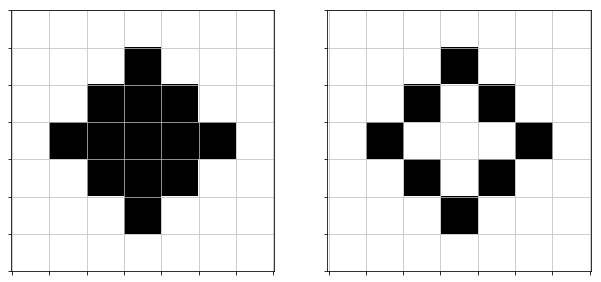

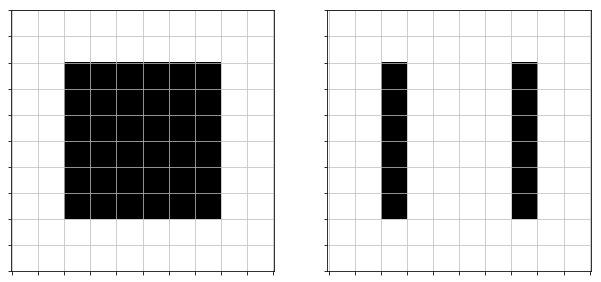

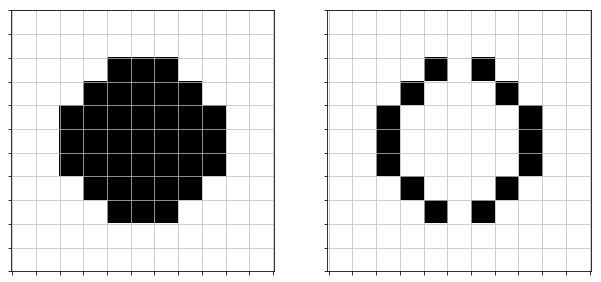

In [2]:
########################################################################
src1 = read_img('images/q1/1_src.png')
dest1 = read_img('images/q1/1_dest.png')
test1_1 = read_img('images/q1/1_test1.png')
test1_2 = read_img('images/q1/1_test2.png')

# Learns patter from src1, dest1
# draw_img_pair(src1, dest1)
wopl = WOperatorLearner (1, 3)
w_shape = (1, 3)
wopl.sample_image (src1, dest1)

# Prints pattern table
print ('---------- Pattern table ---------')
table = wopl.get_samples ()
for key in table:
    w = int_to_window (key, 2, w_shape)
    print (w.tolist (), end=' ')
    print ('zeros = ' + str (table[key][0]) + ', uns = ' + 
           str (table[key][1]))

# Creates W-Operator
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape)

# Transform src1
res1 = wop.operate_image (src1)
draw_img_pair(src1, res1)

# Tests same operator on test1_1 and tes1_2
draw_img_pair (test1_1, wop.operate_image (test1_1))
draw_img_pair (test1_2, wop.operate_image (test1_2))

Q2. Aprenda o operador 3x3 para detecção de bordas. Treine seu operador nas imagens da pastas images/q2/ usando os pares (q2_src\*.png, q2_dest\*.png). Teste seu operador nas imagens images/q2/q2_test.png e images/q2/q2_test2.png. Algumas das imagens de treino são desenhadas abaixo.

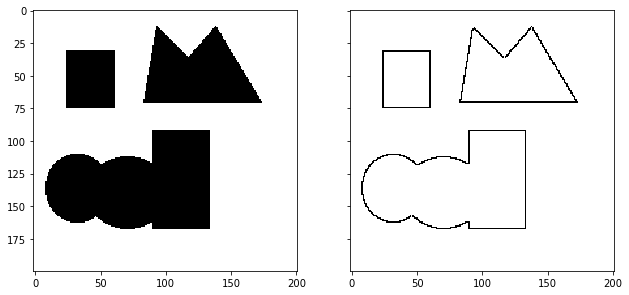

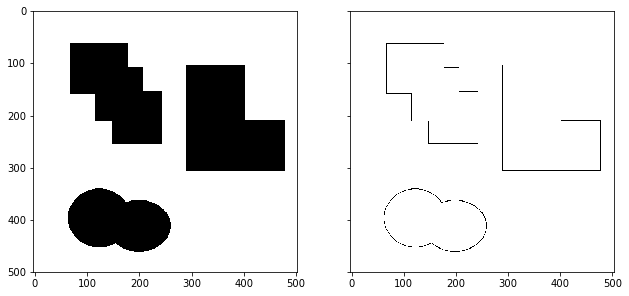

In [3]:
########################################################################
src2_1 = read_img('images/q2/q2_src1.png')
src2_2 = read_img('images/q2/q2_src2.png')
src2_3 = read_img('images/q2/q2_src3.png')
src2_4 = read_img('images/q2/q2_src4.png')
src2_5 = read_img('images/q2/q2_src5.png')
dest2_1 = read_img('images/q2/q2_dest1.png')
dest2_2 = read_img('images/q2/q2_dest2.png')
dest2_3 = read_img('images/q2/q2_dest3.png')
dest2_4 = read_img('images/q2/q2_dest4.png')
dest2_5 = read_img('images/q2/q2_dest5.png')
q2_test = read_img ('images/q2/q2_test.png')
q2_test2 = read_img ('images/q2/q2_test2.png')

# Learns patter from src*, dest*
wopl = WOperatorLearner (3, 3)
w_shape = (3, 3)
wopl.sample_image (src2_1, dest2_1)
wopl.sample_image (src2_2, dest2_2)
wopl.sample_image (src2_3, dest2_3)
wopl.sample_image (src2_4, dest2_4)
wopl.sample_image (src2_5, dest2_5)

# Prints pattern table
# print ('---------- Pattern table ---------')
# table = wopl.get_samples ()
# for key in table:
#     w = int_to_window (key, 2, w_shape)
#     print (w.tolist (), end=' ')
#     print ('zeros = ' + str (table[key][0]) + ', uns = ' 
#         + str (table[key][1]))

# Creates W-Operator
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape)

# Transform q2_test and q2_test2
res1 = wop.operate_image (q2_test)
res2 = wop.operate_image (q2_test2)
draw_img_pair(q2_test, res1)
draw_img_pair(q2_test2, res2)

Q3. Use o algoritmo de aprendizado para obter um operador capaz de eliminar ruído. Use no treinamento as imagens images/q3/q3_src\*.png sempre com o mesmo target images/q3/q3_dest.png. Teste a janela com 5 elementos (cruz). Teste seu operador nas imagens images/q3/q3_test1.png e images/q3/q3_test2.png. Calcule e plote os erros $E_{in}$ e $E_{out}$ obtidos durante o treinamento.

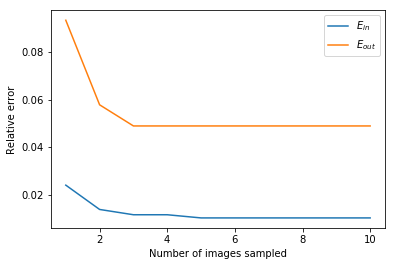

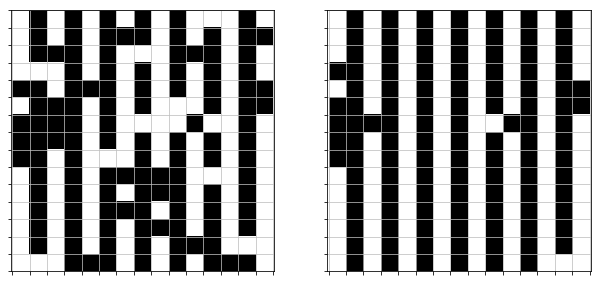

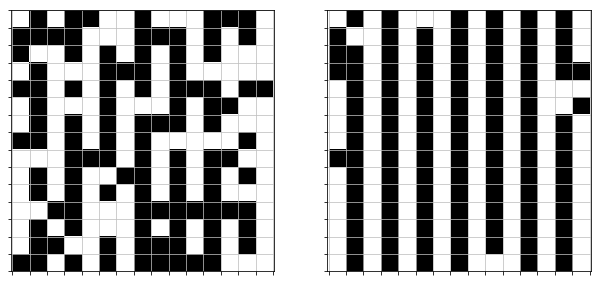

In [5]:
src3_1 = read_img ('images/q3/q3_src1.png')
src3_2 = read_img ('images/q3/q3_src2.png')
src3_3 = read_img ('images/q3/q3_src3.png')
src3_4 = read_img ('images/q3/q3_src4.png')
src3_5 = read_img ('images/q3/q3_src5.png')
src3_6 = read_img ('images/q3/q3_src6.png')
src3_7 = read_img ('images/q3/q3_src7.png')
src3_8 = read_img ('images/q3/q3_src8.png')
src3_9 = read_img ('images/q3/q3_src9.png')
src3_10 = read_img ('images/q3/q3_src10.png')
dest3 = read_img ('images/q3/q3_dest.png')
q3_test1 = read_img ('images/q3/q3_test1.png')
q3_test2 = read_img ('images/q3/q3_test2.png')

e_in_arr = []
e_out_arr = []

# Learns patter from src*, dest* and builds e_in and e_out arrays
mask = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]
wopl = WOperatorLearner (3, 3, mask)
w_shape = (3, 3)

src_list = (src3_1, src3_2, src3_3, src3_4, src3_5, src3_6, src3_7,
            src3_8, src3_9, src3_10)
test_list = (q3_test1, q3_test2)
dest_list = (dest3, dest3, dest3, dest3, dest3, dest3, dest3, dest3,
            dest3, dest3)

## Sample 1
wopl.sample_image (src3_1, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 2
wopl.sample_image (src3_2, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 3
wopl.sample_image (src3_3, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 4
wopl.sample_image (src3_4, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 5
wopl.sample_image (src3_5, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 6
wopl.sample_image (src3_6, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 7
wopl.sample_image (src3_7, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 8
wopl.sample_image (src3_8, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 9
wopl.sample_image (src3_9, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

## Sample 10
wopl.sample_image (src3_10, dest3)
h = wopl.get_hypothesis ()
wop = WOperator (h, w_shape, mask)
e_in = wop_err (wop, src_list, dest_list)
e_out = wop_err (wop, test_list, dest_list)
e_in_arr.append (e_in)
e_out_arr.append (e_out)

# Plots E_in and E_out
ax = plt.gca ()
x = range (1, 11)
plt.plot (x, e_in_arr, label = '$E_{in}$')
plt.plot (x, e_out_arr, label = '$E_{out}$')
handlers, labels = ax.get_legend_handles_labels ()
ax.legend (handlers, labels, loc = 'upper right', numpoints = 1)
plt.ylabel ('Relative error')
plt.xlabel ('Number of images sampled')
plt.show ()

# Transform q2_test and q2_test2
res1 = wop.operate_image (q3_test1)
res2 = wop.operate_image (q3_test2)
# Tests operator
draw_img_pair(q3_test1, res1)
draw_img_pair(q3_test2, res2)

Q4. Projete um operador para aprender a extrair a letra 's' de imagens de texto. Para isso utilize os pares de imagens q4_src\*.png q4_dest\*.png da pasta images/q4/train. Teste seu operador nas imagens da pasta images/q4/test. Utilize a composição de janelas pequenas. Avalie o erro do seu operador comparando a saída obtida por ele com a saída esperada (imagens q4_gt\*.png da pasta images/q4/test).

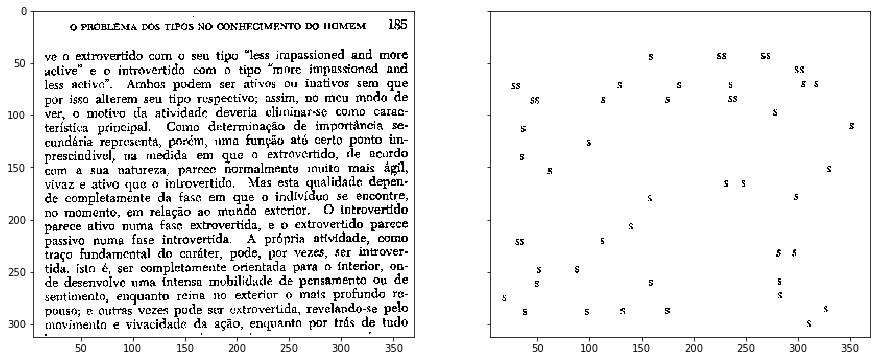

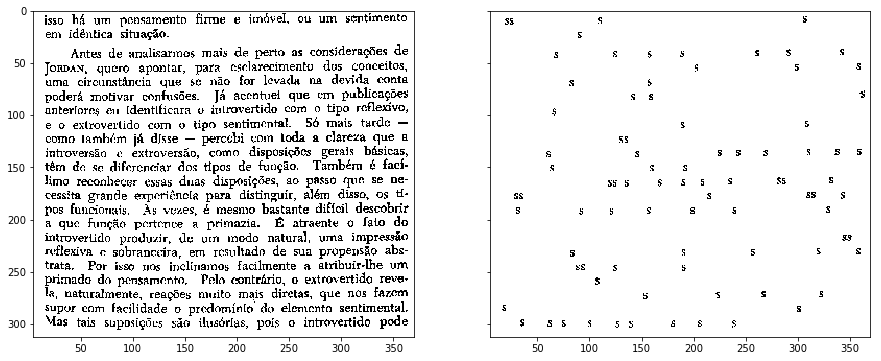

In [6]:
dest4_1a = read_img("images/q4/train/q4_dest1a.png")
src4_1a = read_img("images/q4/train/q4_src1a.png")
dest4_1b = read_img("images/q4/train/q4_dest1b.png")
src4_1b = read_img("images/q4/train/q4_src1b.png")
draw_img_pair(src4_1a, dest4_1a, figsz=(15, 6))
draw_img_pair(src4_1b, dest4_1b, figsz=(15, 6))

Q5. Utilizando a técnica de multiresolução, aprenda o operador capaz de remover ruído das imagens da pasta images/q5/. Utilize os pares de imagens (q5_src\*.png, q5_dest.png) para o treinamento e depois teste seu  operador nas imagens q5_test1.png e q5_test2.png.

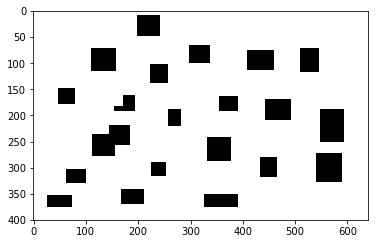

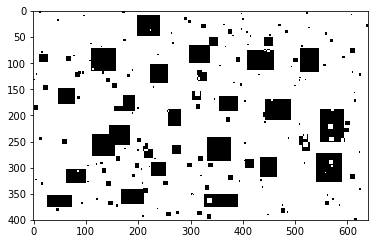

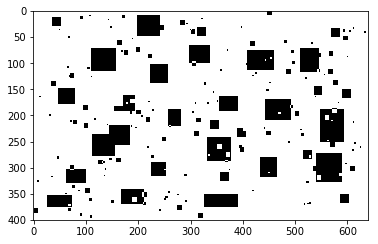

In [7]:
dest5 = read_img("images/q5/q5_dest.png")
src5_1 = read_img("images/q5/q5_src1.png")
src5_2 = read_img("images/q5/q5_src2.png")
draw_img(dest5)
draw_img(src5_1)
draw_img(src5_2)

Q6. Utilize a técnica de envelope, como visto em sala, para remover ruído de imagens. Use o mesmo dataset da questão anterior e as funções de morfologia disponíveis em mac0460_5832/utils.py para definir as funções $\alpha$ e $\beta$. Um exemplo de erosão em uma das imagens de treino é mostrado abaixo. Comente sobre a escolha das funções $\alpha$ e $\beta$.

In [ ]:
src6_1 = read_img("images/q5/q5_src1.png")
draw_img(erosion(src6_1, se_box(2)))

Q7. Utilize a técnica de envelope com multiresolução para aprender um operador capaz de remover ruído de imagens. Para cada uma das janelas, defina funções $\alpha$ e $\beta$ (podem ser diferentes). Compare o resultado obtido aplicando a mistura de técnicas com os resultados das duas questões anteriores.

Q8. A função gen_rand_imgs abaixo retorna um par de imagens. A primeira contém alguns pontos gerados aleatoriamente. A segunda é a dilatação da primeira por um elemento estruturante em forma de cruz. Aprenda o operador capaz de realizar essa transformação, gerando os pares de src e dest. Crie os dados de treinamento baseado na equação vista em sala ($m(\epsilon, \delta, H) = \frac{1}{\epsilon}ln\frac{|H|}{\delta}$). Compare o resultado obtido pelo seu classificador (gere mais pares para teste e ter uma estimativa de $E_{out}$) para $\epsilon = [0.2, 0.1]$ e $\delta = [0.3, 0.2]$.

In [ ]:
def gen_rand_imgs():
    noise = np.zeros((20, 20)).astype(bool)
    num_pixels = 20
    x = np.random.randint(0, 20, num_pixels)
    y = np.random.randint(0, 20, num_pixels)

    for i in range(num_pixels):
        noise[x[i], y[i]] = 1

    return noise, dilation(noise, se_cross(1))

src5_1, dest5_1 = gen_rand_imgs()
src5_2, dest5_2 = gen_rand_imgs()
draw_img_pair(src5_1, dest5_1)
draw_img_pair(src5_2, dest5_2)